In [36]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

**Data Loading**

In [37]:
data = pd.read_csv("/Users/mithi/Downloads/SMSSpamCollection", sep='\t', header=None)
data.head()

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


**Data Preprocessing**

In [38]:
# Checking columns 

col=data.columns
print('Number of columns :', len(col))

Number of columns : 2


In [39]:
# Setting columns names 
data.columns = ['label', 'message']
data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


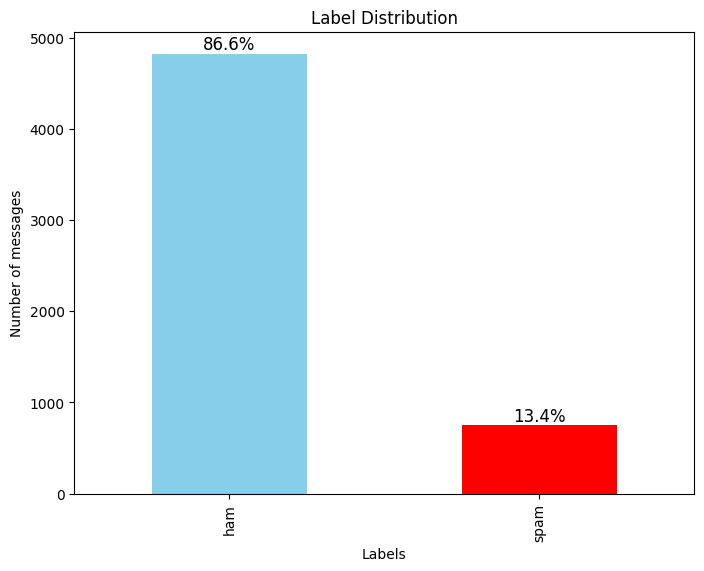

In [40]:
#Checking the label distribution 

labels=data['label'].value_counts()
total= len(data)

ax = labels.plot(kind='bar', color=['skyblue', 'red'], figsize=(8,6))
plt.title("Label Distribution")
plt.xlabel("Labels")
plt.ylabel("Number of messages")

for p in ax.patches:
    ax.annotate(f'{p.get_height()/total*100:.1f}%', 
                (p.get_x() + p.get_width()/2, p.get_height()), 
                ha='center', va='bottom', fontsize=12)
plt.show()

In [41]:
# checking messages lengths 
data['length'] = data['message'].apply(len)
print(data['length'].describe())

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64


In [42]:
# Checking the longest message and the label 
print(data.loc[data['length'].idxmax()])

label                                                    ham
message    For me the love should start with attraction.i...
length                                                   910
Name: 1085, dtype: object


In [43]:
# Checking the shortest message and the label 
print(data.loc[data['length'].idxmin()])

label      ham
message     Ok
length       2
Name: 1925, dtype: object


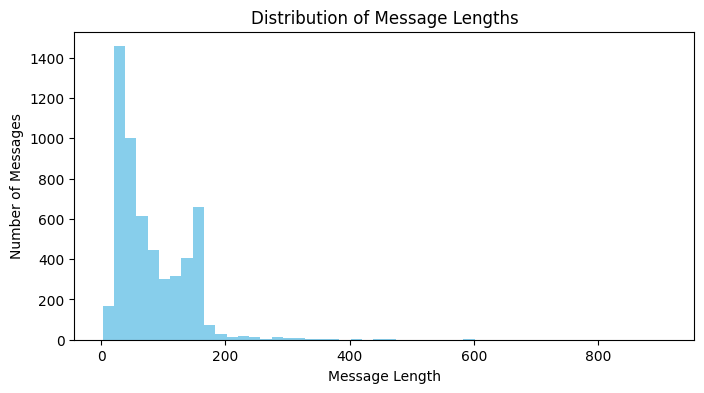

In [44]:
# Histogram of the message lengths 

plt.figure(figsize=(8,4))
plt.hist(data['length'], bins=50, color='skyblue')
plt.title("Distribution of Message Lengths")
plt.xlabel("Message Length")
plt.ylabel("Number of Messages")
plt.show()


In [45]:
# Uppercast letters count per message 
data['num_uppercase'] = data['message'].apply(lambda x: sum(1 for c in x if c.isupper()))
print(data['num_uppercase'].describe())

count    5572.000000
mean        5.633345
std        11.711637
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max       138.000000
Name: num_uppercase, dtype: float64


In [46]:
# Counting extra spaces 
data['extra_spaces'] = data['message'].apply(lambda x: len(x) - len(x.lstrip()) + len(x) - len(x.rstrip())) 
print(data['extra_spaces'].describe())

count    5572.000000
mean        0.034996
std         0.190501
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: extra_spaces, dtype: float64


In [47]:
#Turned everything to lowercase 
data['message_clean'] = data['message'].str.lower().str.strip()
data[['message', 'message_clean']].head(10)

,message,message_clean
0,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ..."
1,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...
4,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro..."
5,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey there darling it's been 3 week's n...
6,Even my brother is not like to speak with me. ...,even my brother is not like to speak with me. ...
7,As per your request 'Melle Melle (Oru Minnamin...,as per your request 'melle melle (oru minnamin...
8,WINNER!! As a valued network customer you have...,winner!! as a valued network customer you have...
9,Had your mobile 11 months or more? U R entitle...,had your mobile 11 months or more? u r entitle...


In [48]:
# Removed special character 
data['message_clean'] = data['message_clean'].str.replace(r'[^a-z\s]', '', regex=True)
data[['message', 'message_clean']].head(10)

,message,message_clean
0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final...
3,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...
5,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey there darling its been weeks now ...
6,Even my brother is not like to speak with me. ...,even my brother is not like to speak with me t...
7,As per your request 'Melle Melle (Oru Minnamin...,as per your request melle melle oru minnaminun...
8,WINNER!! As a valued network customer you have...,winner as a valued network customer you have b...
9,Had your mobile 11 months or more? U R entitle...,had your mobile months or more u r entitled t...


In [49]:
# Tokenized everything 
all_words = data['message_clean'].str.split().explode()
print("Total tokens:", len(all_words))
print("Unique tokens:", all_words.nunique())
print(all_words.value_counts().head(20))

Total tokens: 82872
Unique tokens: 8629
to      2251
i       2249
you     2128
a       1448
the     1334
u       1156
and      971
is       893
in       891
me       791
my       759
for      711
your     677
it       622
of       622
call     581
have     576
on       536
that     514
are      490
Name: message_clean, dtype: int64


**Splitting the data**

In [50]:
# Splitting the dataset 

df_ham = data[data['label'] == 'ham']
df_spam = data[data['label'] == 'spam']

# Split ham into training and test (80% train, 20% test)
ham_train, ham_test = train_test_split(df_ham, test_size=0.2, random_state=42)

# Combine ham_test and all spam for final test set
test_df = pd.concat([ham_test, df_spam]).sample(frac=1, random_state=42)  # shuffle

# Inspect sizes
print("Number of self (ham) training messages:", len(ham_train))
print("Number of test messages:", len(test_df))
print("Number of spam in test set:", len(df_spam))
print("Number of ham in test set:", len(ham_test))

Number of self (ham) training messages: 3860
Number of test messages: 1712
Number of spam in test set: 747
Number of ham in test set: 965


In [51]:
# Convert messages to lowercase and split into words
ham_train['tokens'] = ham_train['message_clean'].str.split()
test_df['tokens'] = test_df['message_clean'].str.split()

# Convert to list of token lists
self_tokens = ham_train['tokens'].tolist()
test_tokens = test_df['tokens'].tolist()

print("Tokenized ham message:", self_tokens[0])
print("Tokenized test message:", test_tokens[0])


Tokenized ham message: ['cool', 'do', 'you', 'like', 'swimming', 'i', 'have', 'a', 'pool', 'and', 'jacuzzi', 'at', 'my', 'house']
Tokenized test message: ['how', 'much', 'are', 'we', 'getting']


In [52]:
def generate_NSA_detectors(ham_tokens, spam_tokens, n_detectors=100):
    
    # Flatten tokens
    ham_vocab = set(word for msg in ham_tokens for word in msg)
    spam_vocab = set(word for msg in spam_tokens for word in msg)
    
    # Spam words that are not in ham
    candidates = list(spam_vocab - ham_vocab)
    
    # Randomly sample detectors
    if len(candidates) < n_detectors:
        return candidates
    else:
        return random.sample(candidates, n_detectors)

detectors = generate_NSA_detectors(self_tokens, test_tokens, n_detectors=100)
print("Number of NSA detectors:", len(detectors))
print("Example NSA detectors:", detectors[:5])


Number of NSA detectors: 100
Example NSA detectors: ['cuck', 'annoncement', 'rowwjhl', 'echo', 'wwwtxtcom']


In [54]:
# If a message contains any non-self detector wors then mark it as a spam

def predict_message(msg_tokens, detectors):
    return int(any(word in msg_tokens for word in detectors))


In [55]:
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix

# Ground truth labels (0=ham, 1=spam)
y_true = test_df['label'].map({'ham':0, 'spam':1}).values

# Make predictions
preds = [predict_message(msg, detectors) for msg in test_tokens]

print("Recall (spam):", recall_score(y_true, preds))
print("Precision (spam):", precision_score(y_true, preds))
print("F1 Score (spam):", f1_score(y_true, preds))
print("Confusion Matrix:\n", confusion_matrix(y_true, preds))


Recall (spam): 0.15930388219544847
Precision (spam): 0.7345679012345679
F1 Score (spam): 0.26182618261826185
Confusion Matrix:
 [[922  43]
 [628 119]]


Detectors: 10, Recall: 0.0201
Detectors: 20, Recall: 0.0268
Detectors: 50, Recall: 0.1084
Detectors: 100, Recall: 0.1593


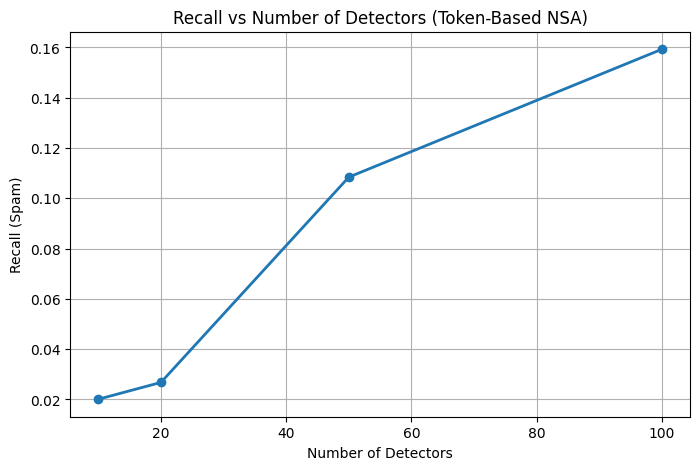

In [56]:
# Defining detector size 

detector_sizes = [10, 20, 50, 100]
recalls = []

#Loop 
for k in detector_sizes:
    det_k = detectors[:k]
    preds_k = [predict_message(msg, det_k) for msg in test_tokens]
    recall = recall_score(y_true, preds_k)
    recalls.append(recall)
    print(f"Detectors: {k}, Recall: {recall:.4f}")

plt.figure(figsize=(8,5))
plt.plot(detector_sizes, recalls, marker='o', linewidth=2)
plt.title("Recall vs Number of Detectors (Token-Based NSA)")
plt.xlabel("Number of Detectors")
plt.ylabel("Recall (Spam)")
plt.grid(True)
plt.show()


In [57]:
from sklearn.metrics import precision_recall_curve, auc

# Calulating borth precision and recall in the same nr of detectors 
detector_sizes = [10, 20, 50, 100]
precision_list = []
recall_list = []

# Number of detectors matched per message
def detector_score(msg_tokens, detectors):
    return sum(word in msg_tokens for word in detectors)
    
#The score for each
for k in detector_sizes:
    det_k = detectors[:k]
    scores = [detector_score(msg, det_k) for msg in test_tokens]
    
    y_pred_binary = [1 if s > 0 else 0 for s in scores]
    
    precision = precision_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)
    
    precision_list.append(precision)
    recall_list.append(recall)
    
    print(f"Detectors: {k}, Precision: {precision:.4f}, Recall: {recall:.4f}")


Detectors: 10, Precision: 0.7895, Recall: 0.0201
Detectors: 20, Precision: 0.6897, Recall: 0.0268
Detectors: 50, Precision: 0.7941, Recall: 0.1084
Detectors: 100, Precision: 0.7346, Recall: 0.1593


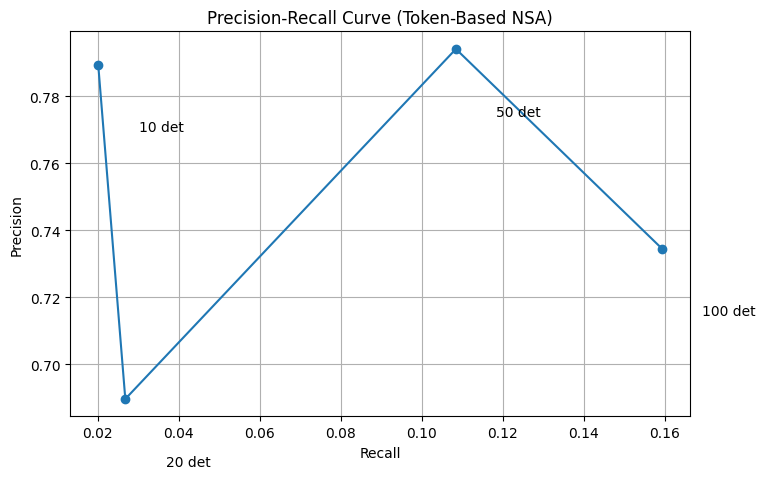

In [58]:
plt.figure(figsize=(8,5))
plt.plot(recall_list, precision_list, marker='o', linestyle='-')
for i, k in enumerate(detector_sizes):
    plt.text(recall_list[i]+0.01, precision_list[i]-0.02, f"{k} det")
plt.title("Precision-Recall Curve (Token-Based NSA)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()


In [54]:
pr_auc = auc(recall_list, precision_list)
print(f"Precision-Recall AUC: {pr_auc:.4f}")


Precision-Recall AUC: 0.1435


Analysis: 

Precision is quite high between 0.6 to 0.8 meaning that the NSA is predicting spam correcting. 

Recall is quire low between 0.02 to 0.16 meaning that the dector is missing alot of spam messages. 

AUC is 0.1435 meaning that the overall performance of the detector is low. 


In [59]:
# Adding predictions to test DataFrame
test_df['predicted_spam'] = [predict_message(msg, detectors) for msg in test_tokens]
test_df['predicted_label'] = test_df['predicted_spam'].map({0: 'ham', 1: 'spam'})

# Messages predicted as spam
print("=== Messages Detected as SPAM ===")
for idx, row in test_df[test_df['predicted_spam'] == 1].iterrows():
    print(f"Actual: {row['label']}, Predicted: {row['predicted_label']}")
    print("Message:", row['message'])
    print("-"*80)

# Messages predicted as ham
print("\n=== Messages Detected as HAM ===")
for idx, row in test_df[test_df['predicted_spam'] == 0].iterrows():
    print(f"Actual: {row['label']}, Predicted: {row['predicted_label']}")
    print("Message:", row['message'])
    print("-"*80)


=== Messages Detected as SPAM ===
Actual: spam, Predicted: spam
Message: Double Mins & Double Txt & 1/2 price Linerental on Latest Orange Bluetooth mobiles. Call MobileUpd8 for the very latest offers. 08000839402 or call2optout/LF56
--------------------------------------------------------------------------------
Actual: spam, Predicted: spam
Message: Update_Now - 12Mths Half Price Orange line rental: 400mins...Call MobileUpd8 on 08000839402 or call2optout=J5Q
--------------------------------------------------------------------------------
Actual: spam, Predicted: spam
Message: Sunshine Hols. To claim ur med holiday send a stamped self address envelope to Drinks on Us UK, PO Box 113, Bray, Wicklow, Eire. Quiz Starts Saturday! Unsub Stop
--------------------------------------------------------------------------------
Actual: spam, Predicted: spam
Message: Todays Voda numbers ending 5226 are selected to receive a ?350 award. If you hava a match please call 08712300220 quoting claim code 1

In [60]:
avg_matches_spam = sum(detector_score(msg, detectors) for msg, label in zip(test_tokens, y_true) if label==1) / sum(y_true)
avg_matches_ham = sum(detector_score(msg, detectors) for msg, label in zip(test_tokens, y_true) if label==0) / (len(y_true)-sum(y_true))
print("Average detector matches per spam message:", avg_matches_spam)
print("Average detector matches per ham message:", avg_matches_ham)


Average detector matches per spam message: 0.17670682730923695
Average detector matches per ham message: 0.046632124352331605


Analysis: 

Spam messages are detected on average 0.177 times per messages. 
Ham messages are detected low, around 0.047 per messages. 

Overall it's good cas it means that the detectors are mmostly firing on spam and not ham which is good for NSA. 

Maybe increasing detectors count could improve the low recall. 




In [61]:
predicted_spam = test_df[test_df['predicted_spam'] == 1]
predicted_ham = test_df[test_df['predicted_spam'] == 0]

print("=== Predicted SPAM Messages ===")
display(predicted_spam[['message', 'label']].head(10))

print("\n=== Predicted HAM Messages ===")
display(predicted_ham[['message', 'label']].head(10))


=== Predicted SPAM Messages ===


,message,label
5055,Double Mins & Double Txt & 1/2 price Linerenta...,spam
3010,Update_Now - 12Mths Half Price Orange line ren...,spam
2115,Sunshine Hols. To claim ur med holiday send a ...,spam
3298,Todays Voda numbers ending 5226 are selected t...,spam
2311,You have won a Nokia 7250i. This is what you g...,spam
4948,Great News! Call FREEFONE 08006344447 to claim...,spam
1915,New TEXTBUDDY Chat 2 horny guys in ur area 4 j...,spam
3619,Hey check it da. I have listed da.,ham
4149,Please call Amanda with regard to renewing or ...,spam
2708,Great NEW Offer - DOUBLE Mins & DOUBLE Txt on ...,spam



=== Predicted HAM Messages ===


,message,label
1237,How much are we getting?,ham
1060,EASTENDERS TV Quiz. What FLOWER does DOT compa...,spam
1798,Can i get your opinion on something first?,ham
2524,"Sorry, I'll call later",ham
3181,There the size of elephant tablets & u shove u...,ham
348,One small prestige problem now.,ham
935,Dear Matthew please call 09063440451 from a la...,spam
3376,:),ham
5102,This msg is for your mobile content order It h...,spam
1882,Ok.. Ü finishing soon?,ham


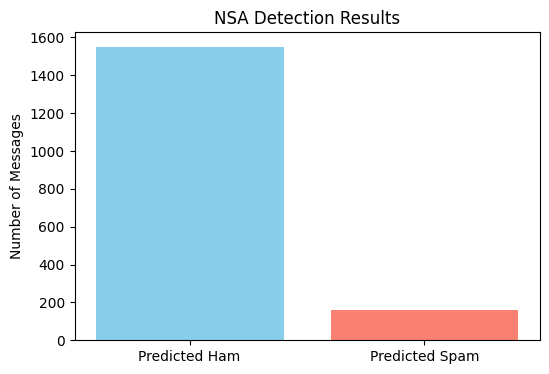

In [62]:
counts = [len(predicted_ham), len(predicted_spam)]
plt.figure(figsize=(6,4))
plt.bar(['Predicted Ham','Predicted Spam'], counts, color=['skyblue','salmon'])
plt.ylabel("Number of Messages")
plt.title("NSA Detection Results")
plt.show()


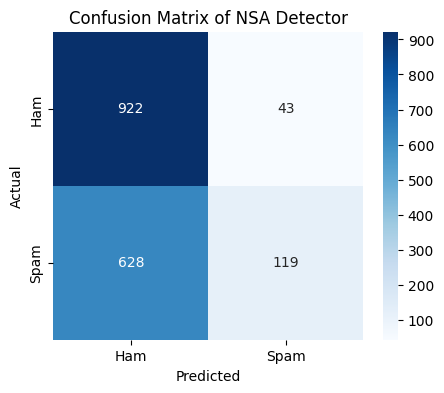

In [65]:
# True labels: 1 for spam, 0 for ham
y_true = test_df['label'].map({'ham':0, 'spam':1}).values
y_pred = test_df['predicted_label'].map({'ham':0, 'spam':1}).values

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham','Spam'], yticklabels=['Ham','Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of NSA Detector')
plt.show()

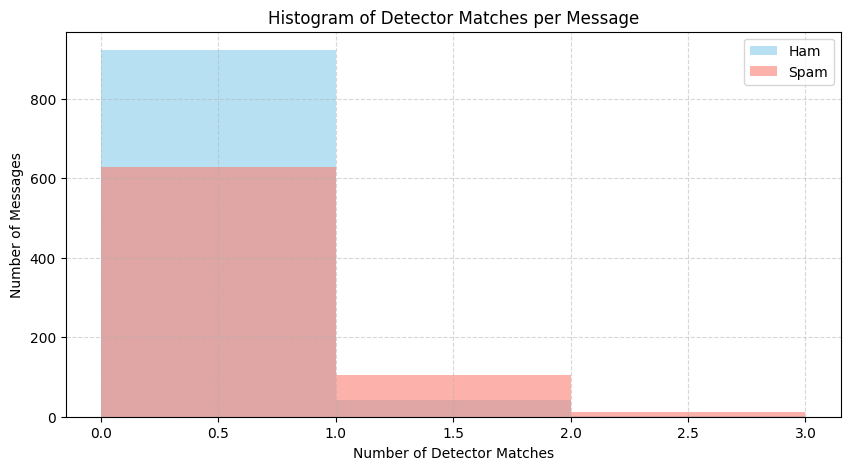

In [66]:
# Compute detector matches per message
matches_per_message = [detector_score(msg, detectors) for msg in test_tokens]

# Separate by true label
matches_spam = [score for score, label in zip(matches_per_message, y_true) if label == 1]
matches_ham  = [score for score, label in zip(matches_per_message, y_true) if label == 0]

plt.figure(figsize=(10,5))
plt.hist(matches_ham, bins=range(max(matches_per_message)+2), alpha=0.6, label='Ham', color='skyblue')
plt.hist(matches_spam, bins=range(max(matches_per_message)+2), alpha=0.6, label='Spam', color='salmon')
plt.xlabel("Number of Detector Matches")
plt.ylabel("Number of Messages")
plt.title("Histogram of Detector Matches per Message")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
